# Nearest Neighbour Search with KD-Trees

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np

from collections import namedtuple, deque 
from pprint import pformat

cor = ['#fad390', '#f6b93b', '#fa983a', '#e58e26', '#f8c291', '#e55039', '#eb2f06', '#b71540']
cog = ['#b8e994', '#78e08f', '#38ada9', '#079992']
cob = ['#6a89cc', '#4a69bd', '#1e3799', '#0c2461', '#82ccdd', '#60a3bc', '#3c6382', '#0a3d62']

---
##### Summary
* Goal: Implement an efficient Nearest Neighbour algorithm based on k-d trees.
* Methods:
    1. Write a series of functions to recursively build a tree given input points, and find given a new point its NN in the tree.
    2. Visualise decision boundary and splitting planes for a few datasets.
* Details:
    1. [K-d Tree (Wikipedia)](https://en.wikipedia.org/wiki/K-d_tree)
    2. [An introductory tutorial on k-d trees, Moore, 1991](https://www.ri.cmu.edu/pub_files/pub1/moore_andrew_1991_1/moore_andrew_1991_1.pdf).
    3.  Bishop, PRML, Chapter 2.
___


In [2]:
class Node(namedtuple('Node', 'location left_child right_child')):
    def __repr__(self):
        return pformat(tuple(self))


def kdtree(point_list, depth):
    """Construct kd-tree recursively from a dataset."""
    try:
        k = len(point_list[0])-1  # assumes all points have the same dimension
    except IndexError as e:       # if not point_list:
        return None
    # Select axis based on depth so that axis cycles through all valid values
    axis = depth % k

    # Sort point list and choose median as pivot element
    point_list.sort(key=lambda x: x[axis])
    median = len(point_list) // 2  # choose median

    # Create node and construct subtrees
    return Node(
        location=point_list[median],
        left_child=kdtree(point_list[:median], depth+1),
        right_child=kdtree(point_list[median+1:], depth+1)
    )

def find_leaf(point, tree, depth=0, _route=None, k=2):
    """Run point through tree."""
    if not _route:
        _route = []
    _route.append(tree)
    t = tree.left_child if point[depth % k] < tree.location[depth % k] else tree.right_child
    return find_leaf(point, t, depth + 1, _route) if t else (tree.location, _route, point)


def distance(point, node): return np.sum(np.square(np.array(point) - np.array(node)[:-1]))


def inspect_branch(stack, point, current_best):
    """Inspect subbranch to find closer nodes to point than current best."""
    while len(stack) != 0:
        root = stack.pop()
        d = distance(point, root.location)
        current_best = (root.location, d) if d < current_best[1] else current_best
        stack.append(root.right_child)    if root.right_child    else None
        stack.append(root.left_child)     if root.left_child     else None
    return current_best


def find_NN(leaf, route, point, tree):
    """Find Nearest Neighbour by unwinding recursion from the leaf node
       to the root of tree, check the other branch if necessary"""
    current_best = (leaf, distance(point, leaf))
    current_branch = 'L' if point[0] < tree.location[0] else 'R'
    for subtree in route[1:][::-1]:
        d = distance(point, subtree.location)
        if d < current_best[1]:
            # go back up the tree to the root and inspect sub-branch if
            # necessary
            current_best = inspect_branch([subtree], point, current_best)
    # inspect other branch from root node if necessary (worst case)
    if distance(point, tree.location) < current_best[1]:
        current_best = (tree.location, distance(point, tree.location))
        current_best = inspect_branch([tree.right_child] if current_branch == 'L' else [tree.left_child], point, current_best)
    return current_best


def kdtree_draw(point_list, depth=0, memory=None, split_dir=None, boundary=None):
    """
    2-d tree drawing class.
    Works by passing to each child a memory of its parent and grand-parent's coordinates and
    splitting plane limits. Then it draws its own horizontal or vertical split with limits
    based on that information.
    """
    try:
        k = len(point_list[0]) - 1
    except IndexError as e:
        return None

    axis = depth % k
    point_list.sort(key=lambda x: x[axis])
    median = len(point_list) // 2
    bot_lim_x, top_lim_x, bot_lim_y, top_lim_y = boundary

    if memory is None:
        # At root, initialise memory
        memory = deque(maxlen=2)
        memory.append([0, 0, bot_lim_x, top_lim_x])
        xr, yr, _ = point_list[median]
        memory.append([xr, yr, bot_lim_y, top_lim_y])

        plt.vlines(x=xr, ymin=bot_lim_y, ymax=top_lim_y, colors='r')

    # vertical split
    elif axis == 0:
        nx, ny = memory  # parent and grandparent's memory
        xc, yc, _ = point_list[median]
        nx_minus, nx_plus, ny_pos = *nx[-2:], ny[1]
        if split_dir == 'L':  # left child
            memory.append([xc, yc, nx_minus, ny_pos])
            x_low, x_upp = nx_minus, ny_pos
        else:  # right child
            memory.append([xc, yc, ny_pos, nx_plus])
            x_low, x_upp = ny_pos, nx_plus

        plt.vlines(x=xc, ymin=x_low, ymax=x_upp, colors='r')

    # horizontal split
    elif axis == 1:
        ny, nx = memory  # parent and grandparent's memory
        xc, yc, _ = point_list[median]
        ny_minus, ny_plus, nx_pos = *ny[-2:], nx[0]
        if split_dir == 'L':  # left child
            memory.append([xc, yc, ny_minus, nx_pos])
            x_low, x_upp = ny_minus, nx_pos
        else:  # right child
            memory.append([xc, yc, nx_pos, ny_plus])
            x_low, x_upp = nx_pos, ny_plus

        plt.hlines(y=yc, xmin=x_low, xmax=x_upp, colors='b')

    # Create node and construct subtrees
    return Node(
        location=point_list[median],
        left_child=kdtree_draw(point_list[:median], depth + 1, memory=memory.copy(), split_dir='L', boundary=boundary),
        right_child=kdtree_draw(point_list[median + 1:], depth + 1, memory=memory.copy(), split_dir='R', boundary=boundary)
    )

### Toy dataset Test

In [3]:
point_list = [(2,3,-1), (5,4,-1), (9,6,1), (4,7,-1), (8,1,1), (7,2,1)]
t = kdtree(point_list, 0)
point = (1,1) # test point
NN = find_NN(*find_leaf(point, t), tree=t)
NN # closest parent to test point

((2, 3, -1), 5)

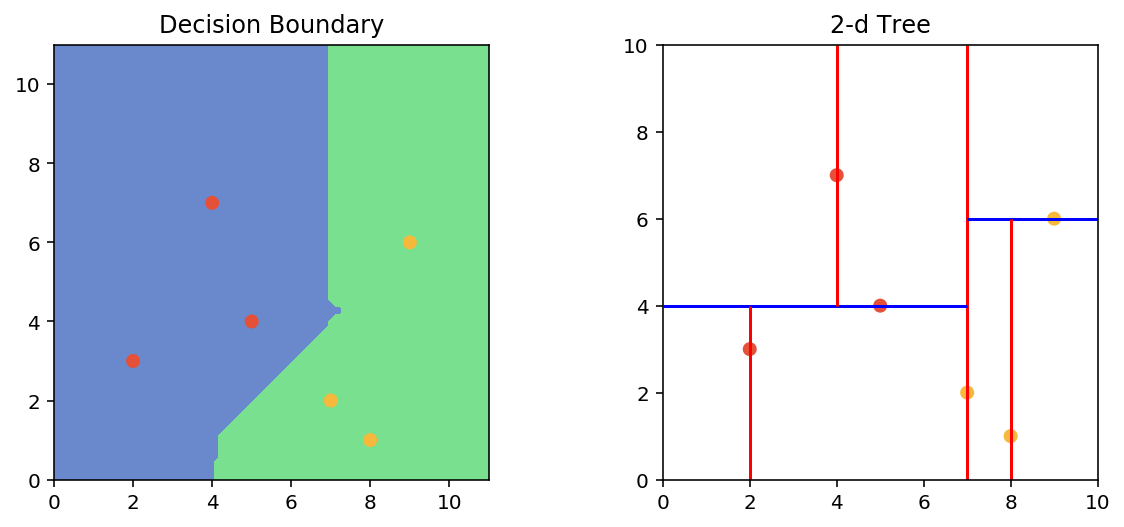

In [4]:
res=100
g1, g2 = np.meshgrid(np.linspace(0,11,res), np.linspace(0,11,res))
g = np.c_[g1.ravel(), g2.ravel()]
g_pred = np.zeros(g.shape[0])
for index, p in enumerate(g):
    NN = find_NN(*find_leaf(tuple(p), t), tree=t)
    g_pred[index] = NN[0][-1]
g_pred = g_pred.reshape(*g1.shape)

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title('Decision Boundary')
plt.contourf(g1, g2, g_pred, colors=[cob[0],cog[1]], levels=[-1,0,1])
x, y, l = [i for (i,_,_) in point_list], [j for (_,j,_) in point_list], [k for (_,_,k) in point_list]
plt.scatter(x,y, c=[cor[1] if x == 1 else cor[5] for x in l]);
plt.axis('square')

plt.subplot(122)
plt.title('2-d Tree')
kdtree_draw(point_list, memory=None, boundary=[0,10,0,10])
x, y, l = [i for (i,_,_) in point_list], [j for (_,j,_) in point_list], [k for (_,_,k) in point_list]
plt.scatter(x,y, c=[cor[1] if x == 1 else cor[5] for x in l]);
plt.axis('square')
plt.xlim([0,10])
plt.ylim([0,10]);

### Overlapping classes Test

In [5]:
n, noise = 100, 0.2
outer_circ_x = np.cos(np.linspace(0, np.pi, n))
outer_circ_y = np.sin(np.linspace(0, np.pi, n))
inner_circ_x = 1 - np.cos(np.linspace(0, np.pi, n))
inner_circ_y = 1 - np.sin(np.linspace(0, np.pi, n)) - .5

D = np.vstack((np.append(outer_circ_x, inner_circ_x),
               np.append(outer_circ_y, inner_circ_y))).T
t = np.hstack([-np.ones(n, dtype=np.intp),
               np.ones(n, dtype=np.intp)])
D += np.random.normal(scale=noise, size=D.shape)
D = np.concatenate((D, t[:,None]), axis=1)
np.random.shuffle(D)
x, y, labels = D[:,0], D[:,1], D[:,2,None]
x_space = np.linspace(np.min(x),np.max(x),2)

In [6]:
point_list = [(i,j,k) for (i,j,k) in zip(x,y,labels)]
boundary = [np.min(D, axis=0)[:-1][0], np.max(D, axis=0)[:-1][0], np.min(D, axis=0)[:-1][1], np.max(D, axis=0)[:-1][1]]
t = kdtree(point_list, 0)

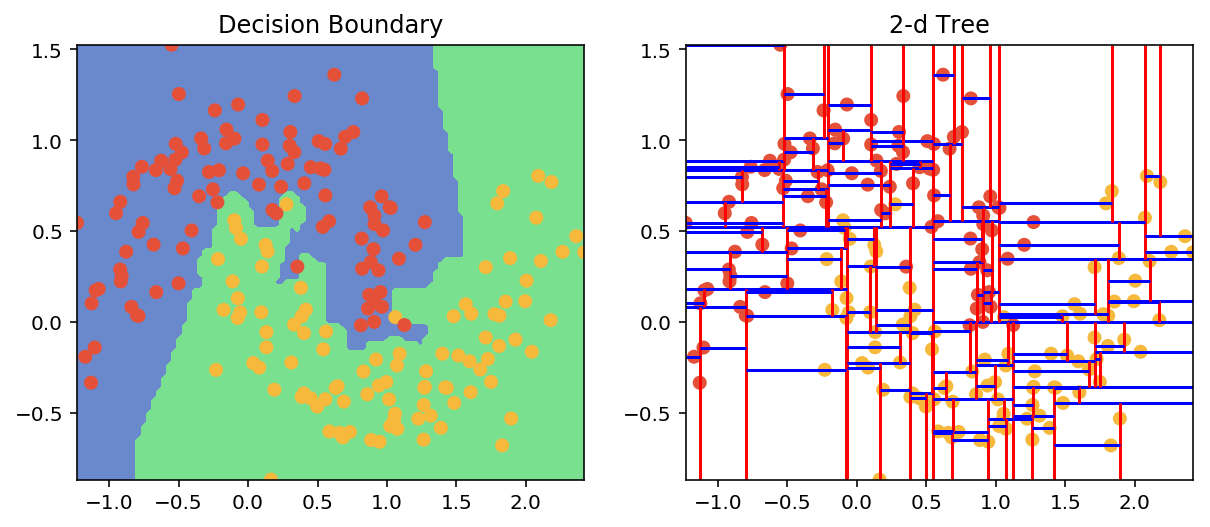

In [7]:
res=100
g1, g2 = np.meshgrid(np.linspace(*boundary[:2],res), np.linspace(*boundary[-2:],res))
g = np.c_[g1.ravel(), g2.ravel()]
g_pred = np.zeros(g.shape[0])
for index, p in enumerate(g):
    NN = find_NN(*find_leaf(tuple(p), t), tree=t)
    g_pred[index] = NN[0][-1]
g_pred = g_pred.reshape(*g1.shape)

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title('Decision Boundary')
plt.contourf(g1, g2, g_pred, colors=[cob[0],cog[1]], levels=[-1,0,1])
plt.scatter(x,y, c=[cor[1] if x == 1 else cor[5] for x in labels])
plt.axis(boundary)

plt.subplot(122)
plt.title('2-d Tree')
kdtree_draw(point_list, memory=None, boundary=boundary)
plt.scatter(x,y, c=[cor[1] if x == 1 else cor[5] for x in labels])
plt.axis(boundary);